In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath("../"))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import matplotlib.pyplot as plt
import glob


from musik import *
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import open3d as o3d
from utils import phantom_builder

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:
voxel_size = np.array([0.001, 0.001, 0.001])
# voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(
    f"{parent}/assets/cardiac_TEE_phantom/esophageal_surface.ply"
)
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

In [3]:
test_phantom = phantom.Phantom(
    voxel_dims=(voxel_size[0], voxel_size[0], voxel_size[0]),
    matrix_dims=body_mask.shape,
    baseline=(1540, 1000),
    seed=None,
)

blood = tissue.Tissue(name="blood", c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(
    name="myocardium", c=1592, rho=1081, sigma=20, scale=0.0001, label=2
)
esophagus = tissue.Tissue(
    name="esophagus", c=1500, rho=1100, sigma=10, scale=0.0001, label=3
)
fat = tissue.Tissue(name="fat", c=1480, rho=970, sigma=15, scale=0.0001, label=4)

heart_file_dir = f"{parent}/assets/cardiac_TEE_phantom"

heart_tissue_list = [blood, myocardium, esophagus]

test_phantom.build_organ_from_mesh(
    surface_mesh, voxel_size[0], heart_tissue_list, dir_path=heart_file_dir
)
test_phantom.set_default_tissue(fat)

Added blood
Added myocardium
Added esophagus


In [4]:
test = test_phantom.get_complete()

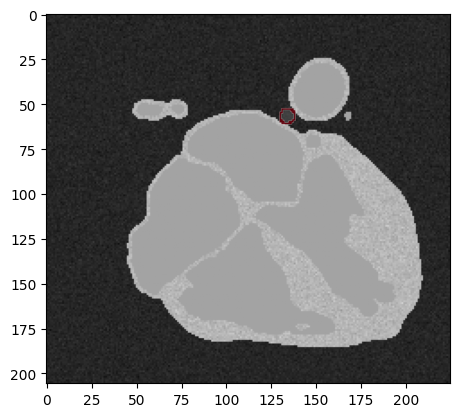

In [5]:
index = 100
plt.imshow(test[0, :, :, index], cmap="gray", vmin=1450, vmax=1650)
plt.imshow(
    body_mask[:, :, index], alpha=(body_mask[:, :, index] > 0) * 0.9, cmap="Reds"
)

# Set up simulation

### Test

In [6]:
num_transducers = 200     # 1000, 3000
transducers = [
    transducer.Focused(
        max_frequency=0.25e6,   # changed, 0.8e6
        elements=128,
        width=20e-3,
        height=20e-3,
        sensor_sampling_scheme="not_centroid",
        sweep=np.pi / 2,    # np.pi / 2,
        ray_num=16,    # changed, 64
        imaging_ndims=2,
        focus_azimuth=100e-3,
        focus_elevation=150e-3,
        cycles=3,
    )
    for i in range(num_transducers)
]


for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)


In [7]:
# get random position
def rand_position_box(xmin, xmax, ymin, ymax, zmin, zmax):
    x = np.random.uniform(xmin, xmax)
    y = np.random.uniform(ymin, ymax)
    z = np.random.uniform(zmin, zmax)
    return [x, y, z]

In [8]:
# ## correct version
# def euler_face_origin_xyz(position):
#     """
#     Return [rx, ry, rz] (radians) so a +Z-forward transducer at `position`
#     faces the origin (0,0,0) in a Y-up world. Roll is set to 0.
#     """
#     x, y, z = position
#     # Vector from transducer -> origin
#     dx, dy, dz = -x, -y, -z

#     # Yaw (about Y): turn in XZ plane toward the origin
#     yaw = np.arctan2(dx, dz)               # ry
#     # Apply additional downward yaw of 90° (π/2 radians)
#     yaw -= np.pi / 2
#     # Pitch (about X): tilt up/down toward the origin
#     horiz = np.hypot(dx, dz)
#     pitch = - np.arctan2(dy, horiz)          # rx


#     # Roll (about Z): keep upright
#     roll = 0                      # rz
#     return [pitch, yaw, roll]


# Correct for now --> get back to fix yaw, pitch, roll
def euler_face_origin_xyz(position):
    """
    Return [rx, ry, rz] (radians) so a +Z-forward transducer at `position`
    faces the origin (0,0,0) in a right-handed world with:
      - roll (x-axis)
      - pitch (y-axis)
      - yaw (z-axis)
    """
    x, y, z = position
    dx, dy, dz = -x, -y, -z  # vector to origin

    # --- Yaw (about Z): rotate in XY plane toward origin ---
    yaw = np.arctan2(dy, dx)  # rz

    # --- Pitch (about Y): tilt up/down toward origin ---
    horiz = np.hypot(dx, dy)
    pitch = np.arctan2(dz, horiz)  # ry

    # --- Roll (about X): keep upright ---
    roll = 0  # rx

    return [yaw, -pitch, roll]

In [9]:
def add_random_rotation_noise(euler, roll_noise_deg=180, yaw_noise_deg=30, pitch_noise_deg=30):

    yaw, pitch, roll = euler

    # Roll noise uniformly from -180° to +180°
    # r_noise_deg = np.random.uniform(-roll_noise_deg, roll_noise_deg)
    # r_noise_rad = np.deg2rad(r_noise_deg)
    roll_noisy = roll #+ r_noise_rad

    # Yaw noise uniformly from -25° to +25°
    y_noise_deg = np.random.uniform(-yaw_noise_deg, yaw_noise_deg)
    y_noise_rad = np.deg2rad(y_noise_deg)
    yaw_noisy = yaw + y_noise_rad

    # Pitch noise uniformly from -25° to +25°
    # p_noise_deg = np.random.uniform(-pitch_noise_deg, pitch_noise_deg)
    # p_noise_rad = np.deg2rad(p_noise_deg)
    pitch_noisy = pitch #+ p_noise_rad

    return [yaw_noisy, pitch_noisy, roll_noisy]


In [10]:
def make_transform_facing_origin(position):
    euler = euler_face_origin_xyz(position)
    T = geometry.Transform(euler, position)
    euler_noisy = add_random_rotation_noise(euler)
    # T = geometry.Transform(euler, position)
    T = geometry.Transform(euler_noisy, position)

    T.translation = np.array(position, dtype=float)
    return T

In [11]:
positions = []
for i in range(num_transducers):
    # random position
    # pos = rand_position_box(0.090, 0.099, -0.095, 0.12, -0.15, 0.15)
    # pos = rand_position_box(0.090, 0.11, -0.07, 0.12, -0.14, 0.10)

    # all at the center
    pos = [0.095, 0.010, 0.000]
    positions.append(pos)

    transform = make_transform_facing_origin(pos)
    test_transducer_set.assign_pose(i, transform)

pos_arr = np.asarray(positions, dtype=float)   # shape: (N,3)


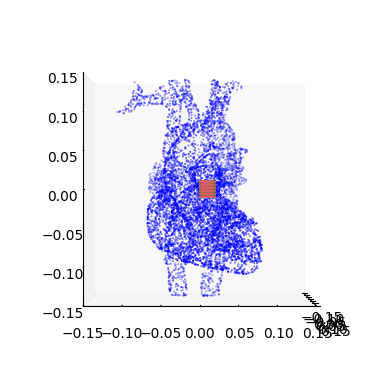

In [12]:
# test plot
# points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/cardiac_TEE_phantom/02_myocardium.obj")).sample_points_uniformly(5000).points)
points = np.array(
    (o3d.io.read_triangle_mesh(f"/{parent}/assets/cardiac_TEE_phantom/01_bloodpool.obj"))
    .sample_points_uniformly(8000)
    .points
)

# test_transducer_set.plot_transducer_coords(
#     scale=0.15, phantom_coords=points, view=(90, 0)
# )
ax = test_transducer_set.plot_transducer_coords(
    scale=0.15, phantom_coords=points, view=(0, 0)
)
# test_transducer_set.plot_transducer_coords(
#     scale=0.15, phantom_coords=points, view=(0, 90)
# )

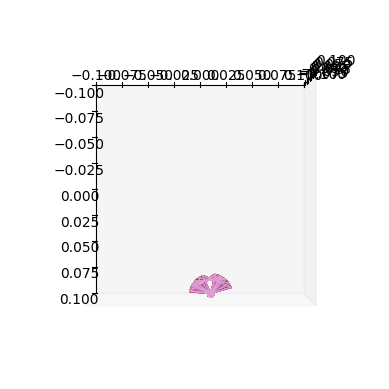

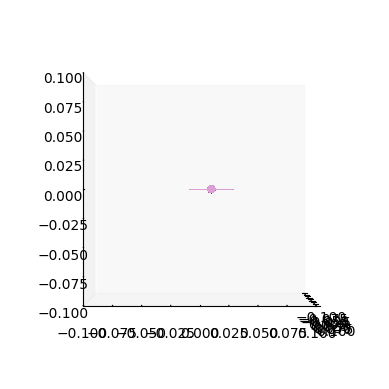

In [13]:
test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(90, 0))
test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(0, 0))
# test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(0, 90))

### Original Code

In [14]:
test_sensor = sensor.Sensor(
    transducer_set=test_transducer_set, aperture_type="transmit_as_receive"
)

In [ ]:
simprops = simulation.SimProperties(
    grid_size=(200e-3, 25e-3, 25e-3),
    voxel_size=(0.5e-3, 0.5e-3, 0.5e-3),
    PML_size=(16, 16, 16),
    PML_alpha=2,
    # t_end=12e-5,  # [s]
    bona=6,  # parameter b/a determining degree of nonlinear acoustic effects
    alpha_coeff=0.5,  # [dB/(MHz^y cm)]
    alpha_power=1.5,
)

In [16]:
test_experiment = experiment.Experiment(
    simulation_path=f"TTE_yaw_only",
    sim_properties=simprops,
    phantom=test_phantom,
    transducer_set=test_transducer_set,
    sensor=test_sensor,
    nodes=1,
    results=None,
    indices=None,
    workers=4,
    additional_keys=[],
)

test_experiment.save()

workers is the number of simulations being prepared simultaneously on a single gpu node. Having many workers is RAM intensive and may not decrease overall runtime


# Run Simulation

In [17]:
test_experiment = experiment.Experiment.load(f"TTE_yaw_only")
test_experiment.run(dry=True)

Number of simulation results (3192) is less than the expected number of simulation results (3200), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 200/200 [00:00<00:00, 248.16it/s]


In [18]:
test_experiment.run(repeat=False)

running with 4 workers

preparation for sim    0 completed in  5.27 seconds
preparation for sim    1 completed in  5.41 seconds
preparation for sim    3 completed in  5.23 seconds
preparation for sim    2 completed in  4.98 seconds
simulation             0 completed in  2.13 seconds
simulation             3 completed in  1.88 seconds
simulation             1 completed in  2.12 seconds
simulation             2 completed in  2.05 seconds
preparation for sim    6 completed in  5.15 seconds
preparation for sim    4 completed in  5.06 seconds
simulation             6 completed in  2.09 seconds
simulation             4 completed in  2.13 seconds
preparation for sim    7 completed in  6.11 seconds
preparation for sim    5 completed in  6.03 seconds
simulation             7 completed in  1.83 seconds
simulation             5 completed in  2.05 seconds
successfully joined 3 preparation processes and 1 run process


# Reconstruction

In [19]:
test_experiment.add_results()

In [20]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [21]:
signals = test_reconstruction.get_signals(
    dimensions=2, matsize=512, downsample=1, workers=16, tgc=10
)

100%|██████████| 3200/3200 [00:57<00:00, 56.01it/s]
200it [00:35,  5.57it/s]


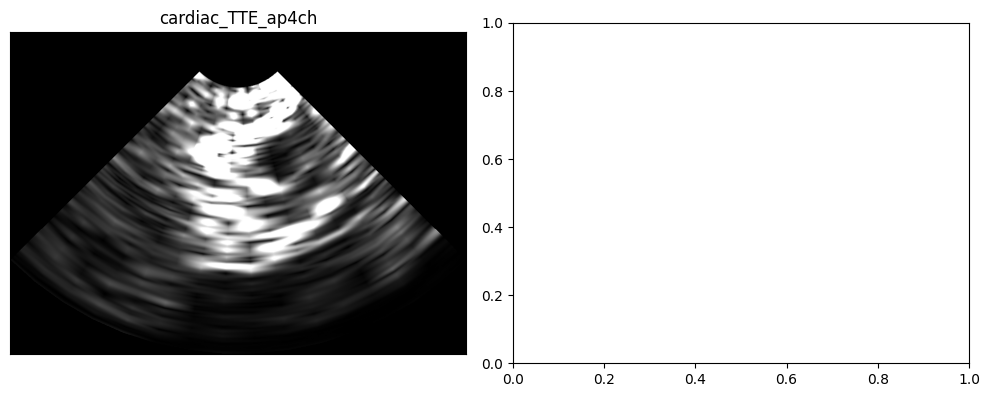

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # 1 row, 2 columns

# --- Image 1: apical 4-chamber ---
axes[0].imshow(signals[0][:, ::-1], vmin=0, vmax=10000, cmap="gray")
axes[0].set_title("cardiac_TTE_ap4ch")
axes[0].set_facecolor("black")
axes[0].set_xticks([])
axes[0].set_yticks([])

# # --- Image 2: apical 2-chamber ---
# axes[1].imshow(signals[1][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# axes[1].set_title("cardiac_TTE_ap2ch")
# axes[1].set_facecolor("black")
# axes[1].set_xticks([])
# axes[1].set_yticks([])

plt.tight_layout()
plt.show()

# plt.imshow(signals[2][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# plt.gca().set_facecolor("black")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.savefig(
#     "cardiac_TTE_parasternal_sax_midpap_2MHz.png",
#     bbox_inches="tight",
#     pad_inches=0,
#     dpi=300,
# )
# plt.title("cardiac_TTE_parasternal_sax_midpap")
# plt.show()

# plt.imshow(signals[3][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# plt.gca().set_facecolor("black")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.savefig(
#     "cardiac_TTE_parasternal_sax_mitral_2MHz.png",
#     bbox_inches="tight",
#     pad_inches=0,
#     dpi=300,
# )

# plt.imshow(signals[4][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# plt.gca().set_facecolor("black")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.savefig(
#     "cardiac_TTE_parasternal_lax_2MHz.png", bbox_inches="tight", pad_inches=0, dpi=300
# )

# plt.imshow(signals[5][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# plt.gca().set_facecolor("black")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.savefig(
#     "cardiac_TTE_subcostal_4ch_2MHz.png", bbox_inches="tight", pad_inches=0, dpi=300
# )

In [23]:
# compute percentiles
p0 = np.nanpercentile(signals, 0)
p95 = np.nanpercentile(signals, 97.5)

# clip and normalize
signals_clipped = np.clip(signals, p0, p95)
signals_normalized = (signals_clipped - p0) / (p95 - p0) * 255

# replace NaNs
signals_normalized = np.nan_to_num(signals_normalized, nan=127).astype(np.uint8)  # or nan=127, nan=255, etc.

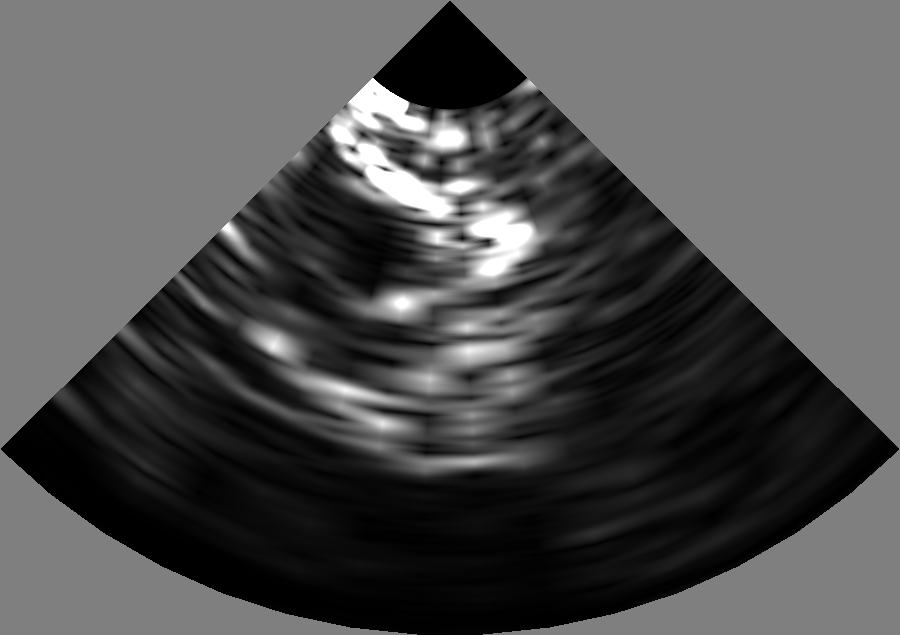

In [24]:
from PIL import Image
Image.fromarray(signals_normalized[0])

In [26]:
img_dir = 'TTE_yaw_only'

# Save all the normalized signals as 8-bit PNG files
os.makedirs(img_dir, exist_ok=True)
for i in tqdm.tqdm(range(signals_normalized.shape[0])):
    Image.fromarray(signals_normalized[i]).save(f'{img_dir}/signals_{i:05d}.png')


100%|██████████| 200/200 [00:05<00:00, 36.88it/s]


In [ ]:
# From your experiment results:
time_array, signal_array = test_experiment.results[index]  # index is your simulation index

# Calculate sampling parameters:
dt = (time_array[-1] - time_array[0]) / time_array.shape[0]  # time step [s]
total_time = time_array[-1] - time_array[0]  # total recording time [s]
c0 = test_experiment.phantom.baseline[0]  # speed of sound [m/s]

# Calculate physical length:
total_physical_length = total_time * c0 / 2  # divide by 2 for round-trip

In [3]:
transform1 = geometry.Transform([-3.14, 0.95, -2.51], [0, 0, 0])
transform2 = geometry.Transform([-0.2, 0, 0], [0, 0, 0])
transform3 = geometry.Transform([0, 0.04, 0], [0, 0, 0])
transform = transform1 * transform2 * transform3
position = np.array([0.09, 0.025, 0.045])
transform.translation = position

In [4]:
transform.rotation.as_matrix()

array([[-0.69100436,  0.3538695 ,  0.63030893],
       [-0.13770518,  0.79156475, -0.59536756],
       [-0.70961275, -0.49819839, -0.49824503]])

In [5]:
transform.translation

array([0.09 , 0.025, 0.045])